In [1]:
# base_dir = '/content/drive/MyDrive/CS760-project'
base_dir = '/Users/nealdesai/Documents/CSClasses/CS760-Machine Learning/VisualSemanticEmbedding'

import warnings
warnings.simplefilter('ignore')

# Imports

In [2]:
# various imports
%matplotlib inline
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from PIL import Image

# set import parameters
matplotlib.rcParams['figure.facecolor'] = '#ffffff'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (4,4)
np.set_printoptions(suppress=True, precision=5)

In [3]:
# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.utils.data as data
from torch.utils.data.dataloader import DataLoader

# torchvision
import torchvision
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchinfo import summary
from torchviz import make_dot

# gensim
import gensim
import gensim.downloader

# GPU Support

In [5]:
# shown computation device. favor supported GPU over CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Data Preparation

In [6]:
# pathes to image dataset
data_dir_path = base_dir + '/data/tiny-imagenet-200'

# flag to determine if embedding matrix should be loaded or generated
embedding_pretrained = True

# random data augmentation
def data_transform():
    return T.Compose([
        T.Resize(64),
        T.ColorJitter(brightness=0.3),
        T.RandomAffine(degrees=45, translate=(0.08,0.08), scale=(0.8,1.2), shear=10),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
    ])
    
# create dataset objects with transofrmations only applied to training data
train_dataset = ImageFolder(data_dir_path + '/train', transform=data_transform())
test_dataset = ImageFolder(data_dir_path + '/test', transform=T.ToTensor())

# download pertrained word2vec model using the Gensim API
pretrain_wv = gensim.downloader.load('glove-wiki-gigaword-200')

# # collect image labels from data directory
d = {}

f = open(data_dir_path+'/words.txt','r') 
while(1):
    try:
        key, val = f.readline().split("\t")
        d[key] = val[:-1]
    except Exception:
        break

# Create embedded matrix with nonzero values
matrix = np.zeros((200,200))
not_in_set = []

# Fill embedding matrix with vectors for training class labels
for i in range(len(train_dataset.classes)):
    all_label_terms = d[train_dataset.classes[i]].split(', ')
    num_words = 0
    for j, label_terms in enumerate(all_label_terms):
        # standardize label strings
        label_terms = label_terms.replace('-','')
        label_terms = label_terms.replace('\'','')
        label_terms = label_terms.lower().replace(' ','_')
        if j == 0:
            train_dataset.classes[i] = label_terms
            
        if not embedding_pretrained:
            try:
                # average vectors for classes with multiple words
                if '_' in label_terms:
                    label_split = label_terms.split('_')
                    for lab in label_split:
                        matrix[i] += pretrain_wv[lab]
                        num_words += 1
                else:
                    matrix[i] += pretrain_wv[str(label_terms)]
                    num_words += 1
            except KeyError:
                not_in_set.append(label_terms)

# save embedding matrix
if not embedding_pretrained:
    matrix = np.reshape(matrix,(200*200))
    np.save('embeddings.npy', matrix)
    
# load embedding matrix and normalize
embeddings = torch.from_numpy(np.load('embeddings.npy').reshape(200,200)).to(device)
embeddings = nn.functional.normalize(embeddings,dim=1)

In [7]:
random_seed = 4
torch.manual_seed(random_seed);

# split data into training and validation sets using stratification
targets = np.array(train_dataset.targets)
train_ind, temp_ind = train_test_split(np.arange(len(targets)),test_size=0.4,shuffle=True,stratify=targets)
test_ind, val_ind = train_test_split(temp_ind,test_size=0.5,stratify=targets[temp_ind])

# create random sampler objects to help with optimization
train_sampler = data.SubsetRandomSampler(train_ind)
val_sampler = data.SubsetRandomSampler(val_ind)

# display number of images in the training and validation sets
len(train_ind), len(val_ind)

(60000, 20000)

In [8]:
# get some examples of closest embedding vector given test word
def test_embedding(word):
    test = torch.tensor(pretrain_wv[str(word)])
    test = torch.reshape(test,(1,200))
    sim = nn.functional.cosine_similarity(embeddings,test,dim=1)
    ind = np.argmax(sim.numpy())
    return train_dataset.classes[ind]

print('Closest training class to shoe:',test_embedding('shoe'))
print('Closest training class to beef:',test_embedding('beef'))
print('Closest training class to child:',test_embedding('child'))

Closest training class to shoe: sock
Closest training class to beef: meat_loaf
Closest training class to child: school_bus


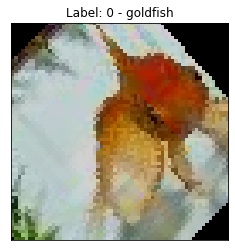

In [9]:
# visualize example of data augmentations
def show_example(img, label):
    plt.imshow(img.permute(1, 2, 0))
    plt.title('Label: '+str(label)+' - '+train_dataset.classes[label])
    plt.yticks([])
    plt.xticks([])
    
show_example(*train_dataset[101])

# Embedding Lookup

In [10]:
# count the number of times the true label is in the top 'n' of the predicted labels
def count_similar(outputs, labels, n=10):
    count = 0

    for output, label in zip(outputs, labels):
        sim_results = []
        label = label.item()

        sim_results = nn.functional.cosine_similarity(embeddings,torch.reshape(output,(1,200)),dim=1)
        sim_results = sim_results.detach().numpy()

        # get n largest results
        max_n_index = np.array(sim_results).argsort()[-n:][::-1]

        # increment count in true label is in top n results
        if label in max_n_index:
            count = count + 1
    return count

# return the top 'n' most similar labels using cosine similarity
def get_labels(outputs, n=10):
    labels = []
    for k, output in enumerate(outputs):
        temp = []
        
        sim_results = nn.functional.cosine_similarity(embeddings,torch.reshape(output,(1,200)),dim=1)
        sim_results = sim_results.detach().numpy()

        # get n largest results
        max_n_index = np.array(sim_results).argsort()[-n:][::-1]
        for j, ind in enumerate(max_n_index):
            temp.append(train_dataset.classes[ind])
        labels.append(temp)
    return labels
    

# Model Fitting and Validation Testing

In [11]:
# fit method used for model training
def fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
    
    n = 5
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        # learning rate decay by sqrt(10) so twice decayed will be magnitude smaller than origianl
        if (epoch+1) % (num_epochs/4) == 0:
            for parm in optimizer.param_groups:
                parm['lr'] /= 3.16   # sqrt(10)
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0

        #訓練フェーズ: training phase
        net.train()
        count = 0

        # main training loop
        for inputs, labels in tqdm(train_loader):
            
            # 勾配の初期化: initalize the gradient
            optimizer.zero_grad()
            
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算: calc output
            outputs = net(inputs)

            # 損失計算: calc loss
            size = outputs.shape[0]
        
            # get indices of true word embedding vectors
            true_embedding = torch.index_select(embeddings, 0, labels)
            
            # get indices of random false word embedding vectors
            rand_ind = torch.randperm(200).to(device)
            rand_ind = [x for x in rand_ind if x not in labels]
            labels_random = torch.tensor(rand_ind[:size]).to(device)
            false_embedding = torch.index_select(embeddings, 0, labels_random)
            
            # combine true and false embedding vectors using a 1 to denote true and -1 to denote false
            output_stack = torch.vstack((outputs,outputs))
            embeddings_stack = torch.vstack((true_embedding,false_embedding))
            sim_stack = torch.vstack((torch.ones(size),-1*torch.ones(size))).reshape(size*2,)
            
            loss = criterion(output_stack, embeddings_stack, sim_stack)
            train_loss += torch.sum(loss).item()

            # 勾配計算: calc gradient
            loss.backward()

            # パラメータ修正: parameter 
            optimizer.step()
            
            train_acc += count_similar(outputs, labels, n)

        #予測フェーズ: test phase
        net.eval()
        count = 0

        # validation testing loop. no actual training done here
        for inputs, labels in val_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算: calc prediction
            outputs = net(inputs)

            # 損失計算: calc loss
            size = outputs.shape[0]
        
            true_embedding = torch.index_select(embeddings, 0, labels)
            
            rand_ind = torch.randperm(200).to(device)
            rand_ind = [x for x in rand_ind if x not in labels]
            labels_random = torch.tensor(rand_ind[:size]).to(device)
            false_embedding = torch.index_select(embeddings, 0, labels_random)
            
            output_stack = torch.vstack((outputs,outputs))
            embeddings_stack = torch.vstack((true_embedding,false_embedding))
            sim_stack = torch.vstack((torch.ones(size),-1*torch.ones(size))).reshape(size*2,)
            
            loss = criterion(output_stack, embeddings_stack, sim_stack)
            val_loss += torch.sum(loss).item()
            
            val_acc += count_similar(outputs, labels, n)
        
        avg_train_loss = train_loss/len(train_ind)
        avg_train_acc = train_acc/len(train_ind)
        avg_val_loss = val_loss/len(val_ind)
        avg_val_acc = val_acc/len(val_ind)
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

# Model Performance

In [12]:
# helper method to show learning curve
def evaluate_history(history):
    #損失と精度の確認: loss and accuracy
    print(f'Initial: loss: {history[0,3]:.5f} accuracy: {history[0,4]:.5f}') 
    print(f'Final: loss: {history[-1,3]:.5f} accuracy: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 5

    # 学習曲線の表示 (損失): learning curve (loss)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='Training')
    plt.plot(history[:,0], history[:,3], 'k', label='Test(Val)')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('# of recursion')
    plt.ylabel('Loss')
    plt.title('Learning Curve (Loss)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度): learning curve (accuracy)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='Training')
    plt.plot(history[:,0], history[:,4], 'k', label='Test(Val)')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('# of recursion')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve (Accuracy)')
    plt.legend()
    plt.show()

#  Image Preview

In [13]:
# show batch of augmented images with the corresponding label 
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 20)

    if net is not None:
      # デバイスの割り当て
        inputs = images.to(device)
        labels = labels.to(device)

      # 予測計算
        outputs = net(inputs)
        predicted = get_labels(outputs, 10)
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(4, 5, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
            predicted_name = predicted[i][0]
          # 正解かどうかで色分けをする
            if label_name in predicted[i][0:5]:
                c = 'green'
            else:
                c = 'blue'
            ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
            ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

In [14]:
# set PyTorch parameters and seed
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

# Data Pipelines

In [15]:
#batch_size = 100
batch_size = 64

# DataLoarder of Training data
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

# DataLoarder of Validation data
val_loader = DataLoader(train_dataset,  batch_size=batch_size, sampler=val_sampler)

# DataLoader of Testing Data
test_loader = DataLoader(test_dataset, batch_size=batch_size)

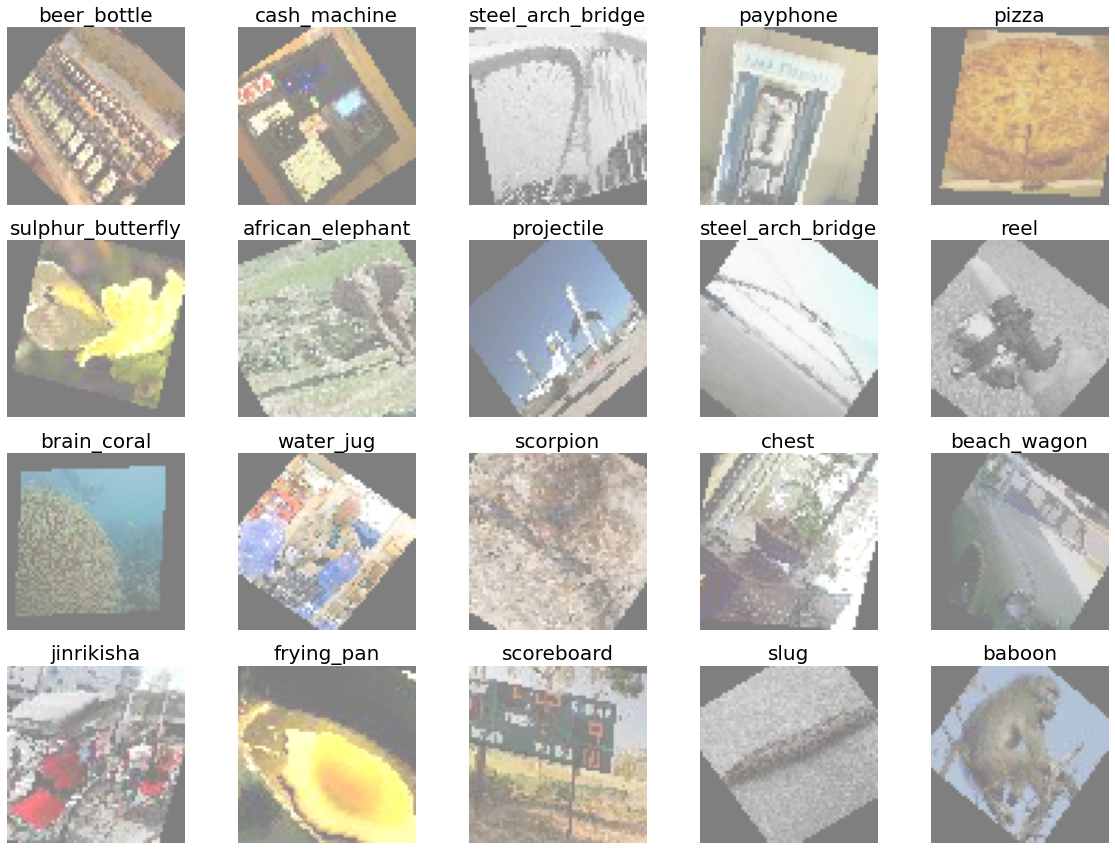

In [16]:
# get the class labels for the training dataset
classes = train_dataset.classes

# show batch of training images
show_images_labels(train_loader, classes, None, None)

# Def Model

### Parameters

In [17]:
# number of nodes needed at output of fully connected layer
n_output = 200 

# number of nodes of hidden layer
n_hidden = 1024

print(f'num hidden nodes: {n_hidden}   num output nodes: {n_output}')

n_hidden: 1024 n_output: 200


### Loss Function

In [18]:
# custom loss function described in the DeViSE paper
# combination using hinge and rank loss with customizable margin
class deviseLoss(nn.Module):
    def __init__(self):
        super(deviseLoss, self).__init__()
        self.margin = torch.tensor(.1, dtype=float).to(device)

    def forward(self, outputs, labels):

        size = outputs.shape[0]
        loss = torch.zeros(size, dtype=float).to(device)

        # get embeddings of true labels
        true_labels_embedding = torch.index_select(embeddings, 0, labels)
        x_mul = torch.mul(nn.functional.normalize(outputs), true_labels_embedding)
        predict_true_similarity = torch.mean(x_mul, dim=1)
        
        # get embeddings of random false labels
        rand_ind = torch.randperm(200).to(device)
        rand_ind = [x for x in rand_ind if x not in labels]
        labels_random = torch.tensor(rand_ind[:size]).to(device)
        false_labels_embedding = torch.index_select(embeddings, 0, labels_random)
        y_mul = torch.mul(nn.functional.normalize(outputs), false_labels_embedding)
        predict_negative_similarity = torch.mean(y_mul, dim=1)

        # hinge loss
        temp = torch.max((self.margin - predict_true_similarity + predict_negative_similarity),
                          torch.tensor(0.0, dtype=float).to(device))
        loss += temp
        loss = torch.sum(loss)
        return loss

### Combined Model

In [22]:
# module object used to define our Visual-Semantic model
class CNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2,2))
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.5)
        self.l1 = nn.Linear(2048, n_hidden) # 16*32*32
        self.l2 = nn.Linear(n_hidden, n_hidden)
        self.l3 = nn.Linear(n_hidden, n_output)
        
        self.features = nn.Sequential(
            
            self.conv1,
            self.relu,
            self.maxpool,
            
            self.conv2,
            self.relu,
            self.bn2,
            self.maxpool,
            self.dropout1,
            
            self.conv3,
            self.relu,
            self.bn3,
            self.maxpool,
            self.dropout1,

        )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout2,
            self.l2,
            self.relu,
            self.l3,
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

### Baseline CNN

In [42]:
# module object used to define our baseline CNN with softmax output
class VanillaCNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2,2))
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.5)
        self.l1 = nn.Linear(2048, n_hidden) # 16*32*32
        self.l2 = nn.Linear(n_hidden, n_output)
        
        self.features = nn.Sequential(
            
            self.conv1,
            self.relu,
            self.maxpool,
            
            self.conv2,
            self.relu,
            self.bn2,
            self.maxpool,
            self.dropout1,
            
            self.conv3,
            self.relu,
            self.bn3,
            self.maxpool,
            self.dropout1,

        )

        self.classifier = nn.Sequential(
           self.l1,
           self.relu,
           self.dropout2,
           self.l2)

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

### Create model instance

In [43]:
# init randam, 乱数初期化
torch_seed()

# create visual-semantic model instance
net = CNN(n_output, n_hidden).to(device)

# display model summary
summary(net,(batch_size,3,64,64),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Sequential: 1-1                        [64, 32, 8, 8]            8,272
├─Conv2d: 1-2                            [64, 16, 64, 64]          1,216
├─ReLU: 1-3                              [64, 16, 64, 64]          --
├─MaxPool2d: 1-4                         [64, 16, 32, 32]          --
├─Conv2d: 1-5                            [64, 16, 32, 32]          2,320
├─ReLU: 1-6                              [64, 16, 32, 32]          --
├─BatchNorm2d: 1-7                       [64, 16, 32, 32]          32
├─MaxPool2d: 1-8                         [64, 16, 16, 16]          --
├─Dropout: 1-9                           [64, 16, 16, 16]          --
├─Conv2d: 1-10                           [64, 32, 16, 16]          4,640
├─ReLU: 1-11                             [64, 32, 16, 16]          --
├─BatchNorm2d: 1-12                      [64, 32, 16, 16]          64
├─M

In [44]:
# define loss function used for training
criterion = nn.CosineEmbeddingLoss(margin=0.5, reduction='sum')
#criterion = deviseLoss().to(device)

# learning step 学習率
lr = 1e-3

# define optimizer. DeViSE paper used SGD but we have turned to Adam for faster convergence
optimizer = optim.Adam(net.parameters(),lr=lr)
#optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# epoch 繰り返し回数
num_epochs = 100

# vector to track model learning history 評価結果記録用
history = np.zeros((0,5))

# learning: 学習
history = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history)

# save current model weights
torch.save(net.state_dict(), './devise_cosineembedloss.pth')

n_hidden: 1024 n_output: 200


<All keys matched successfully>

In [ ]:
# display loss/accuracy learning curves from model training 評価
evaluate_history(history)

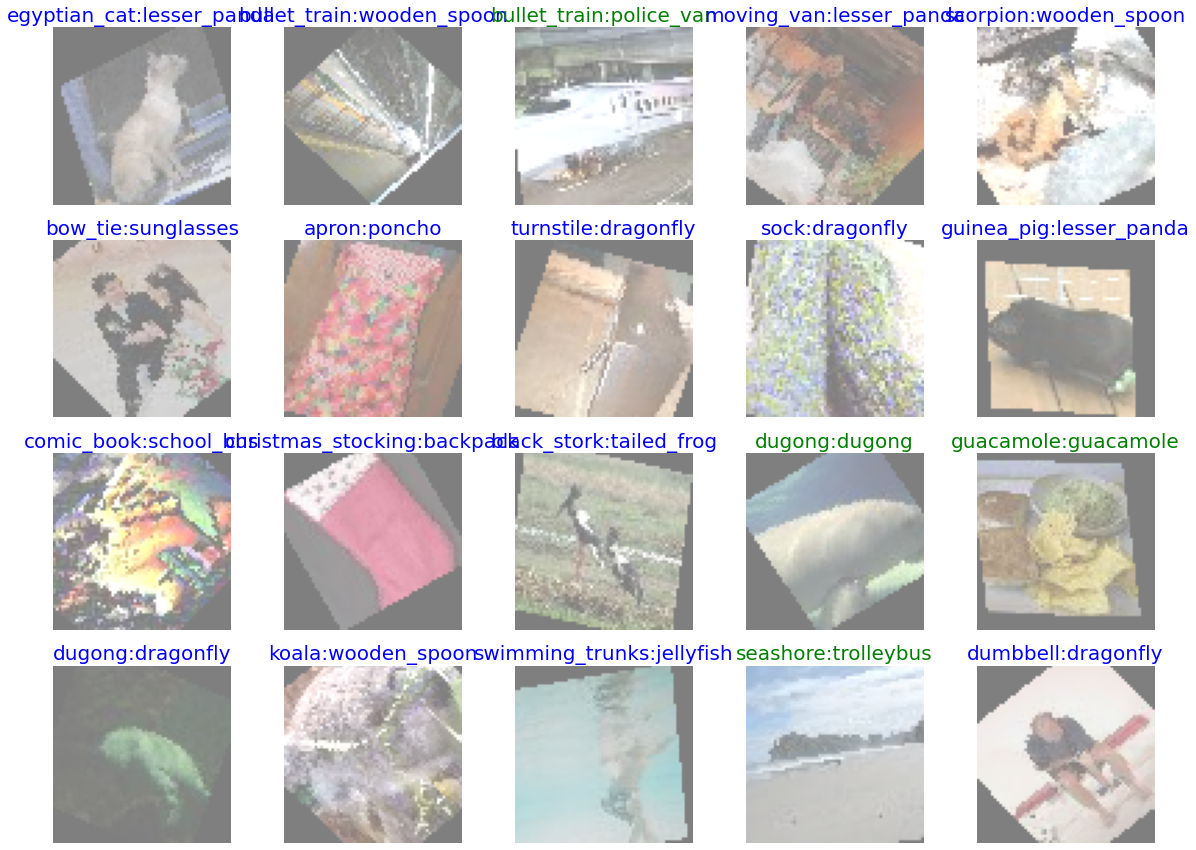

In [26]:
# display images with true label and predicted label
# green titles represent the true label being in the top 5 predicted labels
show_images_labels(val_loader, classes, net, device)

# Zero-Shot learning

In [ ]:
# compare base softmax CNN with the combined visual-semantic model
combine_cnn = CNN(n_output, n_hidden)
combine_cnn.load_state_dict(torch.load('devise_bestcnn_cosineembedloss.pth'))

vanilla_cnn = VanillaCNN(n_output, n_hidden)
vanilla_cnn.load_state_dict(torch.load('cnn_best_so_far_40epoch.pth'))

In [45]:
# transformation to fit CIFAR images to model input
zero_shot_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

In [100]:
from torchvision.datasets import CIFAR100

# directory to download CIFAR dataset to
data_dir_path_cifar = 'data/CIFAR100/cifar-100-python'

# create dataloader objects for CIFAR image data and labels
train_data_cifar = CIFAR100(download=True,root=data_dir_path_cifar,transform=zero_shot_transform)
train_dl_cifar = DataLoader(train_data_cifar, batch_size=batch_size, shuffle=False)

# create data iterator for CIFAR dataloader
cifar_iter = iter(train_dl_cifar)

Files already downloaded and verified


In [ ]:
# print first few CIFAR labels
cifar_label = train_data_cifar.classes
print(cifar_label[0:10])

# find number of labels that overlap between the original dataset and CIFAR
count = 0
for train_class in classes:
    for cifar_class in cifar_label:
        if train_class == cifar_class:
            count += 1
print('Num Overlapping Labels:', count)

In [ ]:
# print the true CIFAR label along with the topn predicted labels
for inputs, labels in cifar_iter:
    outputs_combined = net(inputs)
    for i, output in enumerate(outputs_combined):
        print('True:',cifar_label[labels[i]])
        pred = pretrain_wv.similar_by_vector(output.detach().numpy(),topn=10)
        print('Pred:',pred)

In [ ]:
# evaluate the semantic similarity of the outputs from the baseline cnn against the ground truth labels
label_freqs = {}
class_metric = {}
for inputs, labels in cifar_iter:
    outputs = CNN_Base(inputs)
    for i, output in enumerate(outputs):
        label = cifar_label[labels[i]]
        pred = pretrain_wv.similar_by_vector(output.detach().numpy(),topn=3)
        if label not in label_freqs:
            label_freqs[label] = 1
            class_metric[label] = 0
        else:
            label_freqs[label] += 1
        new = 0
        for tup in pred:
            new += tup[1]
        class_metric[label] += new / 3  

In [ ]:
# Normalize based on frequency of each class label
normalized_base = {}
for key in label_freqs:
    raw_total = class_metric[key]
    freq = label_freqs[key]
    normalized_base[key] = raw_total / freq
    
print(normalized_base)

In [ ]:
print(label_freqs)
tot = 0
for k in label_freqs:
    tot += label_freqs[k]
    
print(tot)
# print(class_metric)

In [ ]:
# evaluate the semantic similarity of the outputs from the combined model against the ground truth labels
label_freqs_c = {}
class_metric_c = {}
for inputs, labels in cifar_iter:
    outputs = net(inputs)
    for i, output in enumerate(outputs):
        label = cifar_label[labels[i]]
        pred = pretrain_wv.similar_by_vector(output.detach().numpy(),topn=3)
        if label not in label_freqs_c:
            label_freqs_c[label] = 1
            class_metric_c[label] = 0
        else:
            label_freqs_c[label] += 1
        new = 0
        for tup in pred:
            new += tup[1]
        class_metric_c[label] += new / 3  

In [ ]:
normalized_combined = {}
for key in label_freqs_c:
    raw_total = class_metric_c[key]
    freq = label_freqs_c[key]
    normalized_combined[key] = raw_total / freq

print(normalized_combined)

In [ ]:
print(label_freqs_c)
tot = 0
for k in label_freqs_c:
    tot += label_freqs_c[k]
    
print(tot)
# print(class_metric)

In [131]:
# Calculate baseline similarity of unrelated words. This is our control
c = 0
total = 0
for ic in classes:
    for key in label_freqs_c:
        sim = 0
        c += 1
#         print(ic,key)
        lst_ic = ic.split('_')
        lst_key = key.split('_')
        div_count = 0
        for i in lst_ic:
            for j in lst_key:
                sim += pretrain_wv.similarity(i,j)
                div_count += 1
        if div_count == 0:
            div_count = 1
        sim /= div_count
        total += sim
    if c % 10000 == 0:
        break
control = total/c
print('Baseline similarity: ', control)

from statistics import mean
mean_cnn = mean(normalized_base.values())
mean_combined = mean(normalized_combined.values())
print('Vanilla CNN similarity: ', mean_cnn)
print('Combined Model similarity: ', mean_combined)
        

Baseline similarity:  0.11563021878555464
Vanilla CNN similarity:  0.31229827755452083
Combined Model similarity:  0.6252381296277046


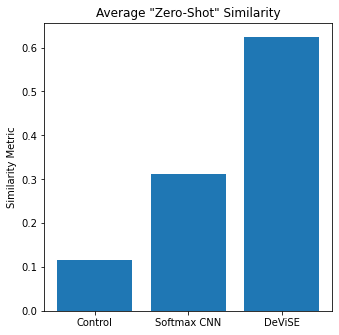

In [136]:
# manually created array with calculated average similarities to avoid needing to repeat calculations
similarities = np.array([0.11563,0.312298, 0.625238])

# create figure to visualize the average semantic relation between prediction and true label for each model
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lbls = ['Control', 'Softmax CNN', 'DeViSE']
vals = [control, mean_cnn, mean_combined]
ax.bar(lbls, vals)
ax.set_ylabel('Similarity Metric')
ax.set_title('Average "Zero-Shot" Similarity')
plt.show()